In [44]:
import json, os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.models import Model
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import Concatenate
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input
import tensorflow as tf
from tensorflow.keras import optimizers

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
dataset=pd.DataFrame()
dataset = pd.read_pickle('/content/drive/MyDrive/dataset_prepro.pickle')

In [11]:
y=dataset[['labels.case_type','labels.sub_case_type','labels.damage_type','labels.assignment_type']]
X=dataset.drop(['labels.case_type','labels.sub_case_type','labels.damage_type','labels.assignment_type'], axis=1)

In [12]:
X=X.drop(['language'],axis=1)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state=0)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(2938, 3) (2938, 4)
(735, 3) (735, 4)


In [17]:
X_train

,mail_content,attachments_filename,attachments_content
1948,sans mevrouw contacteren verzekeraar bijlage ...,"v pr bestekken, foto, geg my tp Polis VIVIUM P...",den tue dec subject onze ref ref dossier nr c...
2148,sans contactons qualit trouverez annexe docum...,Agt déclaration + factures crt signale erreur ...,sent mar subject claration sinistre ass cuvet...
217,annexe transmettons document concernant missi...,"MISSION_ASSIGNEMENT devis 6620,00 euro htva m...",blvd roi ii bic tva rpm entreprise agr nation...
670,annexe transmettons document concernant missi...,MISSION_ASSIGNEMENT in mail décla photo mail ...,blvd roi ii bic tva rpm entreprise agr nation...
1242,sans mevrouw contacteren verzekeraar bijlage ...,PR Bestek voor schade binnendeuren Aangifte PR...,cr commercieel medewerker sent tue subject on...
...,...,...,...
835,annexe transmettons document concernant missi...,IMG_20201227_160810805 (5900799).jpg MISSION_A...,blvd roi ii bic tva rpm entreprise agr nation...
3264,bijlage wij document betrekking opdracht toev...,MISSION_ASSIGNEMENT mail makelaar - aangifte w...,nv koning bic btw verzekeringsmaatschappij to...
1653,annexe transmettons document concernant missi...,MISSION_ASSIGNEMENT déclaration,blvd roi ii bic tva rpm entreprise agr nation...
2607,br mercredi septembre concerne sinistre sans ...,32674509 tiers verison + devis + pas de dcl à ...,rc entreprises conditions particulieres contr...


In [25]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 30000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 500
# This is fixed.
EMBEDDING_DIM = 100

In [32]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X['mail_content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train_mc = tokenizer.texts_to_sequences(X_train['mail_content'].values)
X_train_mc = pad_sequences(X_train_mc,maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data X_train_mc:', X_train_mc.shape)

X_test_mc = tokenizer.texts_to_sequences(X_test['mail_content'].values)
X_test_mc = pad_sequences(X_test_mc,maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data X_train_mc:', X_test_mc.shape)

Found 565 unique tokens.
Shape of data X_train_mc: (2938, 500)
Shape of data X_train_mc: (735, 500)


In [33]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X['attachments_filename'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train_af = tokenizer.texts_to_sequences(X_train['attachments_filename'].values)
X_train_af = pad_sequences(X_train_af,maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data X_train_af:', X_train_af.shape)

X_test_af = tokenizer.texts_to_sequences(X_test['attachments_filename'].values)
X_test_af = pad_sequences(X_test_af,maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data X_test_af:', X_test_af.shape)

Found 15862 unique tokens.
Shape of data X_train_af: (2938, 500)
Shape of data X_test_af: (735, 500)


In [35]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X['attachments_content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train_ac = tokenizer.texts_to_sequences(X_train['attachments_content'].values)
X_train_ac = pad_sequences(X_train_ac,maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data X_train_ac:', X_train_ac.shape)

X_test_ac = tokenizer.texts_to_sequences(X_test['attachments_content'].values)
X_test_ac = pad_sequences(X_test_ac,maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data X_train_ac:', X_test_ac.shape)

Found 43767 unique tokens.
Shape of data X_train_ac: (2938, 500)
Shape of data X_train_ac: (735, 500)


In [37]:
#One-hot multi output
y1_train=pd.DataFrame(columns=pd.get_dummies(y[['labels.assignment_type']]).columns)
y1_test=pd.DataFrame(columns=pd.get_dummies(y[['labels.assignment_type']]).columns)
y2_train=pd.DataFrame(columns=pd.get_dummies(y[['labels.case_type']]).columns)
y2_test=pd.DataFrame(columns=pd.get_dummies(y[['labels.case_type']]).columns)
y3_train=pd.DataFrame(columns=pd.get_dummies(y[['labels.sub_case_type']]).columns)
y3_test=pd.DataFrame(columns=pd.get_dummies(y[['labels.sub_case_type']]).columns)
y4_train=pd.DataFrame(columns=pd.get_dummies(y[['labels.damage_type']]).columns)
y4_test=pd.DataFrame(columns=pd.get_dummies(y[['labels.damage_type']]).columns)
# y1_train=y1_train.merge(pd.get_dummies(y_train[['labels.assignment_type']]),how='outer').fillna(0)
y1_train=y1_train.combine_first(pd.get_dummies(y_train[['labels.assignment_type']])).fillna(0)
print('Shape of label tensor Y1 Train:', y1_train.shape)
y1_test=y1_test.combine_first(pd.get_dummies(y_test[['labels.assignment_type']])).fillna(0)
print('Shape of label tensor Y1 Test:', y1_test.shape)

y2_train=y2_train.combine_first(pd.get_dummies(y_train[['labels.case_type']])).fillna(0)
print('Shape of label tensor Y2 Train:', y2_train.shape)
y2_test=y2_test.combine_first(pd.get_dummies(y_test[['labels.case_type']])).fillna(0)
print('Shape of label tensor Y2 Test:', y2_test.shape)

y3_train=y3_train.combine_first(pd.get_dummies(y_train[['labels.sub_case_type']])).fillna(0)
print('Shape of label tensor Y3 Train:', y3_train.shape)
y3_test=y3_test.combine_first(pd.get_dummies(y_test[['labels.sub_case_type']])).fillna(0)
print('Shape of label tensor Y3 Test:', y3_test.shape)

y4_train=y4_train.combine_first(pd.get_dummies(y_train[['labels.damage_type']])).fillna(0)
print('Shape of label tensor Y4 Train:', y4_train.shape)
y4_test=y4_test.combine_first(pd.get_dummies(y_test[['labels.damage_type']])).fillna(0)
print('Shape of label tensor Y4 Test:', y4_test.shape)

Shape of label tensor Y1 Train: (2938, 2)
Shape of label tensor Y1 Test: (735, 2)
Shape of label tensor Y2 Train: (2938, 4)
Shape of label tensor Y2 Test: (735, 4)
Shape of label tensor Y3 Train: (2938, 15)
Shape of label tensor Y3 Test: (735, 15)
Shape of label tensor Y4 Train: (2938, 26)
Shape of label tensor Y4 Test: (735, 26)


In [45]:
#OP NL EN FR
#Optimizer
opt = tf.keras.optimizers.Adam(lr=0.001)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=35)

#Model
input_mc = Input(shape=(500))
input_af = Input(shape=(500))
input_ac = Input(shape=(500))

# model = Sequential()
embeding_mc=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X.shape[1])(input_mc)
embeding_af=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X.shape[1])(input_af)
embeding_ac=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X.shape[1])(input_ac)

s_mc=SpatialDropout1D(0.3)(embeding_mc)
o_mc=LSTM(64, dropout=0.3)(s_mc)
s_af=SpatialDropout1D(0.3)(embeding_af)
o_af=LSTM(64, dropout=0.3)(s_af)
s_ac=SpatialDropout1D(0.3)(embeding_ac)
o_ac=LSTM(64, dropout=0.3)(s_ac)

concat_layer = Concatenate()([o_mc, o_af,o_ac])

o1=Dense(2, activation='softmax',name='assignment_type')(concat_layer)
o2=Dense(4, activation='softmax',name='case_type')(concat_layer)
o3=Dense(15, activation='softmax',name='sub_case_type')(concat_layer)
o4=Dense(26, activation='softmax',name='damage_type')(concat_layer)


epochs = 200
batch_size = 64

model = Model(inputs=[input_mc,input_af,input_ac], outputs=[o1, o2, o3, o4])
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit([X_train_mc,X_train_af,X_train_ac],[y1_train,y2_train,y3_train,y4_train],epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[es])

Epoch 1/200
42/42 [==============================] - 67s 1s/step - loss: 6.7863 - assignment_type_loss: 0.6684 - case_type_loss: 1.1094 - sub_case_type_loss: 2.2461 - damage_type_loss: 2.7625 - assignment_type_accuracy: 0.6145 - case_type_accuracy: 0.5881 - sub_case_type_accuracy: 0.4666 - damage_type_accuracy: 0.3594 - val_loss: 3.9087 - val_assignment_type_loss: 0.5568 - val_case_type_loss: 0.5541 - val_sub_case_type_loss: 1.1316 - val_damage_type_loss: 1.6661 - val_assignment_type_accuracy: 0.6973 - val_case_type_accuracy: 0.7619 - val_sub_case_type_accuracy: 0.6769 - val_damage_type_accuracy: 0.4592
Epoch 2/200
42/42 [==============================] - 61s 1s/step - loss: 3.9577 - assignment_type_loss: 0.5779 - case_type_loss: 0.5312 - sub_case_type_loss: 1.1502 - damage_type_loss: 1.6985 - assignment_type_accuracy: 0.6805 - case_type_accuracy: 0.7617 - sub_case_type_accuracy: 0.6702 - damage_type_accuracy: 0.4592 - val_loss: 3.4525 - val_assignment_type_loss: 0.4596 - val_case_type

In [47]:
score = model.evaluate(x=[X_test_mc,X_test_af,X_test_ac], y=[y1_test, y2_test, y3_test, y4_test], verbose=1)
print("Loss:", score[0])
print("Test Accuracy:", score[1])

23/23 [==============================] - 6s 177ms/step - loss: 5.5256 - assignment_type_loss: 1.0873 - case_type_loss: 0.5223 - sub_case_type_loss: 1.3497 - damage_type_loss: 2.5664 - assignment_type_accuracy: 0.7469 - case_type_accuracy: 0.9088 - sub_case_type_accuracy: 0.7551 - damage_type_accuracy: 0.4667
Loss: 5.525615692138672
Test Accuracy: 1.0872598886489868


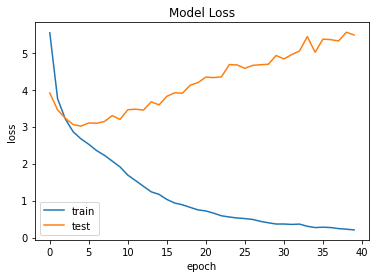

In [48]:
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();
plt.show()

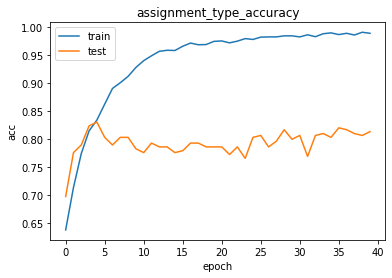

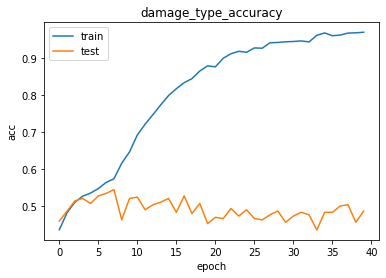

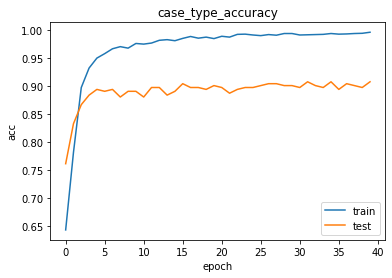

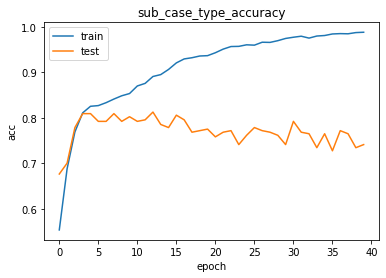

In [49]:
plt.title('assignment_type_accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['assignment_type_accuracy'], label='train')
plt.plot(history.history['val_assignment_type_accuracy'], label='test')
plt.legend()
plt.show();

plt.title('damage_type_accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['damage_type_accuracy'], label='train')
plt.plot(history.history['val_damage_type_accuracy'], label='test')
plt.legend()
plt.show();

plt.title('case_type_accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['case_type_accuracy'], label='train')
plt.plot(history.history['val_case_type_accuracy'], label='test')
plt.legend()
plt.show();

plt.title('sub_case_type_accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['sub_case_type_accuracy'], label='train')
plt.plot(history.history['val_sub_case_type_accuracy'], label='test')
plt.legend()
plt.show();

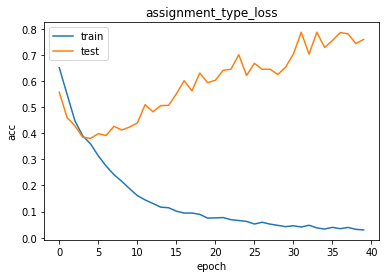

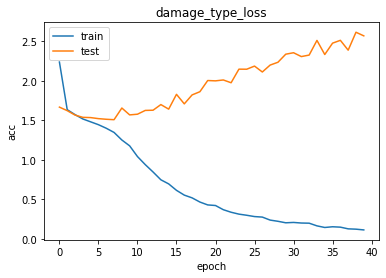

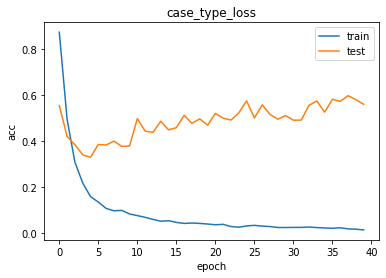

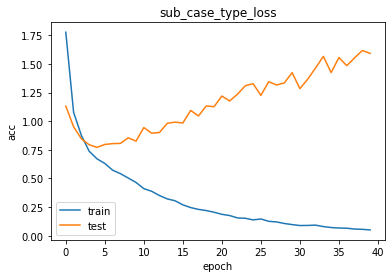

In [50]:
plt.title('assignment_type_loss')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['assignment_type_loss'], label='train')
plt.plot(history.history['val_assignment_type_loss'], label='test')
plt.legend()
plt.show();

plt.title('damage_type_loss')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['damage_type_loss'], label='train')
plt.plot(history.history['val_damage_type_loss'], label='test')
plt.legend()
plt.show();

plt.title('case_type_loss')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['case_type_loss'], label='train')
plt.plot(history.history['val_case_type_loss'], label='test')
plt.legend()
plt.show();

plt.title('sub_case_type_loss')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['sub_case_type_loss'], label='train')
plt.plot(history.history['val_sub_case_type_loss'], label='test')
plt.legend()
plt.show();